### Preparation Steps

In [1]:
!pip install transformers

In [2]:
!pip install jsonlines
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import os
import jsonlines
import shutil

from string import punctuation
import string
import numpy as np

import os, os.path
import pandas as pd

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from os.path import join
from absl import flags
import os
import sys
import csv
import collections
import numpy as np
import time
import math
import json
import random
from copy import copy
from collections import defaultdict as dd

import absl.logging as _logging  # pylint: disable=unused-import
import tensorflow as tf

#import sentencepiece as spm

import argparse

import tensorflow as tf
import numpy as np

from transformers import pipeline

import json

In [3]:
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU is available


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan  3 19:21:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              24W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

---

### Set the function that implements a Zero-Shot-Classification Pipeline.


In [5]:
from transformers import pipeline

# Function to perform zero-shot classification and update JSON object
# The input of the function is a JSON object
def process_batch(batch_lines):
    batch_objects = []

    # Load the zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model = 'cross-encoder/nli-distilroberta-base', device=0)

    for json_line in batch_lines:
        json_object = json.loads(json_line)
        string_value = json_object["string"]
        # Perform zero-shot classification
        labels = classifier(string_value, candidate_labels=["background", "result", "method"])
        # Add the classification results to the JSON object
        if labels['scores'][0] > labels['scores'][1] and labels['scores'][0] > labels['scores'][2]:
            json_object["classification_results"] = labels["labels"][0]
        elif labels['scores'][1] > labels['scores'][0] and labels['scores'][1] > labels['scores'][2]:
            json_object["classification_results"] = labels["labels"][1]
        elif labels['scores'][2] > labels['scores'][0] and labels['scores'][2] > labels['scores'][1]:
            json_object["classification_results"] = labels["labels"][2]

        batch_objects.append(json_object)
    return batch_objects



### Inference on train set.

In [6]:
import csv
import json
from transformers import pipeline
import time


# Process JSONL file in batches and update JSON objects
BATCH_SIZE = 100  # You can adjust the batch size as needed
with open('train.jsonl', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Measure the start time
start_time = time.time()

updated_objects = []
for i in range(0, len(lines), BATCH_SIZE):
    batch_lines = lines[i:i + BATCH_SIZE]
    batch_objects = process_batch(batch_lines)
    updated_objects.extend(batch_objects)
    print(f"Processed {i + len(batch_lines)} lines out of {len(lines)}")

# Measure the end time
end_time = time.time()

# Calculate the total time taken
elapsed_time = end_time - start_time
print(f"Processing completed in {elapsed_time:.2f} seconds.")

# Write the inferred classes, true classes, and citation text to a CSV file
csv_file_path = 'inferred_classes_train.csv'
with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['inferred_class', 'true_class', 'citation_text']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write header
    writer.writeheader()

    # Write data
    for obj in updated_objects:
        writer.writerow({
            'inferred_class': obj.get("classification_results", ""),  # Use get to handle the case when "classification_results" key is not present
            'true_class': obj.get("label", ""),
            'citation_text': obj.get("string", "")
        })

print(f'Inferred classes, true classes, and citation text written to {csv_file_path}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Processed 100 lines out of 8243


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processed 200 lines out of 8243
Processed 300 lines out of 8243
Processed 400 lines out of 8243
Processed 500 lines out of 8243
Processed 600 lines out of 8243
Processed 700 lines out of 8243
Processed 800 lines out of 8243
Processed 900 lines out of 8243
Processed 1000 lines out of 8243
Processed 1100 lines out of 8243
Processed 1200 lines out of 8243
Processed 1300 lines out of 8243
Processed 1400 lines out of 8243
Processed 1500 lines out of 8243
Processed 1600 lines out of 8243
Processed 1700 lines out of 8243
Processed 1800 lines out of 8243
Processed 1900 lines out of 8243
Processed 2000 lines out of 8243
Processed 2100 lines out of 8243
Processed 2200 lines out of 8243
Processed 2300 lines out of 8243
Processed 2400 lines out of 8243
Processed 2500 lines out of 8243
Processed 2600 lines out of 8243
Processed 2700 lines out of 8243
Processed 2800 lines out of 8243
Processed 2900 lines out of 8243
Processed 3000 lines out of 8243
Processed 3100 lines out of 8243
Processed 3200 lin

---
---


### Inference on test set.

In [ ]:
import csv
import json
from transformers import pipeline
import time


# Process JSONL file in batches and update JSON objects
BATCH_SIZE = 100  # You can adjust the batch size as needed
with open('test.jsonl', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Measure the start time
start_time = time.time()

updated_objects = []
for i in range(0, len(lines), BATCH_SIZE):
    batch_lines = lines[i:i + BATCH_SIZE]
    batch_objects = process_batch(batch_lines)
    updated_objects.extend(batch_objects)
    print(f"Processed {i + len(batch_lines)} lines out of {len(lines)}")

# Measure the end time
end_time = time.time()

# Calculate the total time taken
elapsed_time = end_time - start_time
print(f"Processing completed in {elapsed_time:.2f} seconds.")

# Write the inferred classes, true classes, and citation text to a CSV file
csv_file_path = 'inferred_classes.csv'
with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['inferred_class', 'true_class', 'citation_text']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write header
    writer.writeheader()

    # Write data
    for obj in updated_objects:
        writer.writerow({
            'inferred_class': obj.get("classification_results", ""),  # Use get to handle the case when "classification_results" key is not present
            'true_class': obj.get("label", ""),
            'citation_text': obj.get("string", "")
        })

print(f'Inferred classes, true classes, and citation text written to {csv_file_path}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Processed 100 lines out of 1861


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processed 200 lines out of 1861
Processed 300 lines out of 1861
Processed 400 lines out of 1861
Processed 500 lines out of 1861
Processed 600 lines out of 1861
Processed 700 lines out of 1861
Processed 800 lines out of 1861
Processed 900 lines out of 1861
Processed 1000 lines out of 1861
Processed 1100 lines out of 1861
Processed 1200 lines out of 1861
Processed 1300 lines out of 1861
Processed 1400 lines out of 1861
Processed 1500 lines out of 1861
Processed 1600 lines out of 1861
Processed 1700 lines out of 1861
Processed 1800 lines out of 1861
Processed 1861 lines out of 1861
Processing completed in 127.70 seconds.
Inferred classes, true classes, and citation text written to inferred_classes.csv


---
---


### Inference on validation set.

In [ ]:
import csv
import json
from transformers import pipeline
import time


# Process JSONL file in batches and update JSON objects
BATCH_SIZE = 100  # You can adjust the batch size as needed
with open('dev.jsonl', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Measure the start time
start_time = time.time()

updated_objects = []
for i in range(0, len(lines), BATCH_SIZE):
    batch_lines = lines[i:i + BATCH_SIZE]
    batch_objects = process_batch(batch_lines)
    updated_objects.extend(batch_objects)
    print(f"Processed {i + len(batch_lines)} lines out of {len(lines)}")

# Measure the end time
end_time = time.time()

# Calculate the total time taken
elapsed_time = end_time - start_time
print(f"Processing completed in {elapsed_time:.2f} seconds.")

# Write the inferred classes, true classes, and citation text to a CSV file
csv_file_path = 'inferred_classes_val.csv'
with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['inferred_class', 'true_class', 'citation_text']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write header
    writer.writeheader()

    # Write data
    for obj in updated_objects:
        writer.writerow({
            'inferred_class': obj.get("classification_results", ""),  # Use get to handle the case when "classification_results" key is not present
            'true_class': obj.get("label", ""),
            'citation_text': obj.get("string", "")
        })

print(f'Inferred classes, true classes, and citation text written to {csv_file_path}')

Processed 100 lines out of 916
Processed 200 lines out of 916
Processed 300 lines out of 916
Processed 400 lines out of 916
Processed 500 lines out of 916
Processed 600 lines out of 916
Processed 700 lines out of 916
Processed 800 lines out of 916
Processed 900 lines out of 916
Processed 916 lines out of 916
Processing completed in 51.42 seconds.
Inferred classes, true classes, and citation text written to inferred_classes_val.csv


---

### Set the function that calculates all evaluation metrics for the model's infered results across every data set.


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_multiclass_classification(y_true, y_pred, class_labels):
    

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision (micro, macro, weighted)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    print(f'Precision (Micro/Macro/Weighted): {precision_micro:.4f} / {precision_macro:.4f} / {precision_weighted:.4f}')

    # Recall (micro, macro, weighted)
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    print(f'Recall (Micro/Macro/Weighted): {recall_micro:.4f} / {recall_macro:.4f} / {recall_weighted:.4f}')

    # F1 Score (micro, macro, weighted)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    print(f'F1 Score (Micro/Macro/Weighted): {f1_micro:.4f} / {f1_macro:.4f} / {f1_weighted:.4f}')

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred, labels=class_labels)

    # Create a DataFrame for better visualization with class labels
    conf_mat_df = pd.DataFrame(conf_mat, index=class_labels, columns=class_labels)

    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

### Measure the performance of inferred data on the train dataset.

     inferred_class  true_class  \
0        background  background   
1            result  background   
2            result  background   
3            method  background   
4            result  background   
...             ...         ...   
8238         result  background   
8239         method  background   
8240         result  background   
8241         result      method   
8242         method  background   

                                          citation_text  
0     However, how frataxin interacts with the Fe-S ...  
1     In the study by Hickey et al. (2012), spikes w...  
2     The drug also reduces catecholamine secretion,...  
3     By clustering with lowly aggressive close kin ...  
4     Ophthalmic symptoms are rare manifestations of...  
...                                                 ...  
8238  Importantly, the results of Pascalis et al. (2...  
8239  As suggested by Nguena et al, there is a need ...  
8240  Skeletal muscle is also a primary site of dise...  

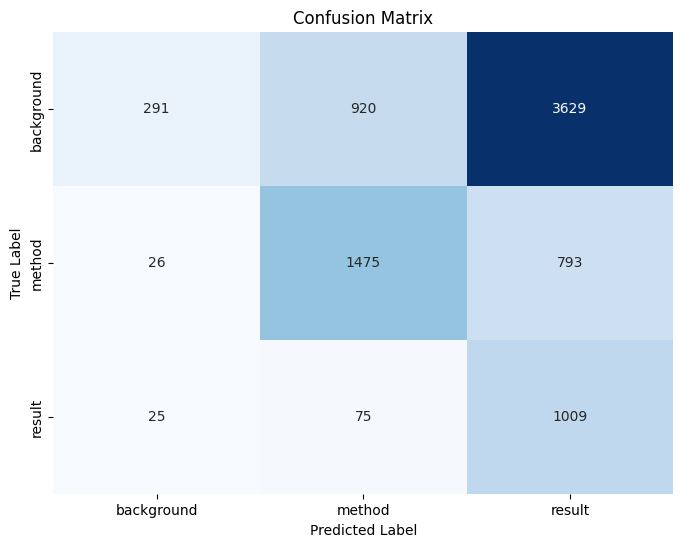

In [8]:
import pandas as pd

# Specify the path to the CSV file
csv_file_path = 'inferred_classes_train.csv'

# Load the CSV file into a DataFrame
df_train = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_train)

# call the function
evaluate_multiclass_classification(df_train["true_class"], df_train["inferred_class"], ['background','method','result'])

In [9]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df_train['check'] = df_train["true_class"] + df_train["inferred_class"]
# Count occurrences of each unique string in the 'check' column
check_counts1 = df_train['check'].value_counts()

# Display the result
print(check_counts1)

backgroundresult        3629
methodmethod            1475
resultresult            1009
backgroundmethod         920
methodresult             793
backgroundbackground     291
resultmethod              75
methodbackground          26
resultbackground          25
Name: check, dtype: int64


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the evalaution metrics.
precision_per_class = precision_score(df_train["true_class"], df_train["inferred_class"], average=None)
recall_per_class = recall_score(df_train["true_class"], df_train["inferred_class"], average=None)
f1_per_class = f1_score(df_train["true_class"], df_train["inferred_class"], average=None)

class_labels = ["background", "method", "result"]

# Print the evaluation metrics.
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i} ({class_labels[i]}): Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

Class 0 (background): Precision=0.8509, Recall=0.0601, F1-Score=0.1123
Class 1 (method): Precision=0.5972, Recall=0.6430, F1-Score=0.6192
Class 2 (result): Precision=0.1858, Recall=0.9098, F1-Score=0.3086


### Measure the performance of inferred data on the test dataset.


In [ ]:
import pandas as pd

# Specify the path to the CSV file
csv_file_path = 'inferred_classes.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df)

     inferred_class  true_class  \
0            result  background   
1            result      result   
2            result  background   
3            result      method   
4            method  background   
...             ...         ...   
1856         result      result   
1857         result  background   
1858         result      method   
1859         result  background   
1860         method      method   

                                          citation_text  
0     Chapel, as well as X10 [2], UPC [3] , CoArray ...  
1     In addition, the result of the present study s...  
2     Several instruments that more specifically add...  
3     Organotypic hippocampal slice cultures\nInterf...  
4     Activated PBMC are the basis of the standard P...  
...                                                 ...  
1856  Additionally, no sex differences were detected...  
1857  WBRT (40Gy in 20 fractions) along with concurr...  
1858  The data obtained from this crosssectional sur...  

Accuracy: 0.3546
Precision (Micro/Macro/Weighted): 0.3546 / 0.5601 / 0.6876
Recall (Micro/Macro/Weighted): 0.3546 / 0.5333 / 0.3546
F1 Score (Micro/Macro/Weighted): 0.3546 / 0.3490 / 0.3009


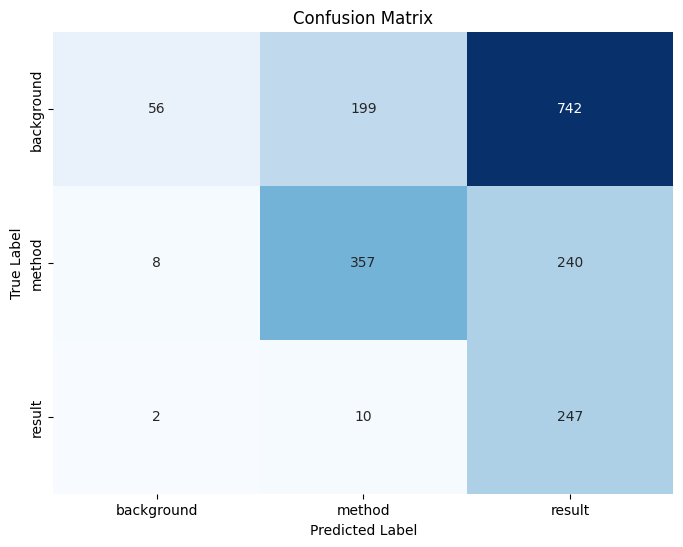

In [ ]:
evaluate_multiclass_classification(df["true_class"], df["inferred_class"], ['background','method','result'])

In [ ]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df['check'] = df["true_class"] + df["inferred_class"]
# Count occurrences of each unique string in the 'check' column
check_counts = df['check'].value_counts()

# Display the result
print(check_counts)

backgroundresult        742
methodmethod            357
resultresult            247
methodresult            240
backgroundmethod        199
backgroundbackground     56
resultmethod             10
methodbackground          8
resultbackground          2
Name: check, dtype: int64


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the evaluation metrics.
precision_per_class = precision_score(df["true_class"], df["inferred_class"], average=None)
recall_per_class = recall_score(df["true_class"], df["inferred_class"], average=None)
f1_per_class = f1_score(df["true_class"], df["inferred_class"], average=None)

class_labels = ["background", "method", "result"]

# Print the evalaution metrics.
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i} ({class_labels[i]}): Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

Class 0 (background): Precision=0.8485, Recall=0.0562, F1-Score=0.1054
Class 1 (method): Precision=0.6307, Recall=0.5901, F1-Score=0.6097
Class 2 (result): Precision=0.2010, Recall=0.9537, F1-Score=0.3320


### Measure the performance of inferred data on the validation dataset.


    inferred_class  true_class  \
0           result      result   
1           result  background   
2           result      result   
3           result  background   
4           result      result   
..             ...         ...   
911         result      result   
912         method  background   
913         method  background   
914         result      method   
915         method      method   

                                         citation_text  
0    These results are in contrast with the finding...  
1    …nest burrows in close proximity of one anothe...  
2    This is clearly in contrast to the results of ...  
3    …in a subset of alcoholics (Chen et al., 2004;...  
4    This result is consistent with the conclusions...  
..                                                 ...  
911  Our results are consistent with those of a pre...  
912  Some of these peptides act as neurotoxins on t...  
913  Therefore, despite an apparent higher number o...  
914  According to Xu 

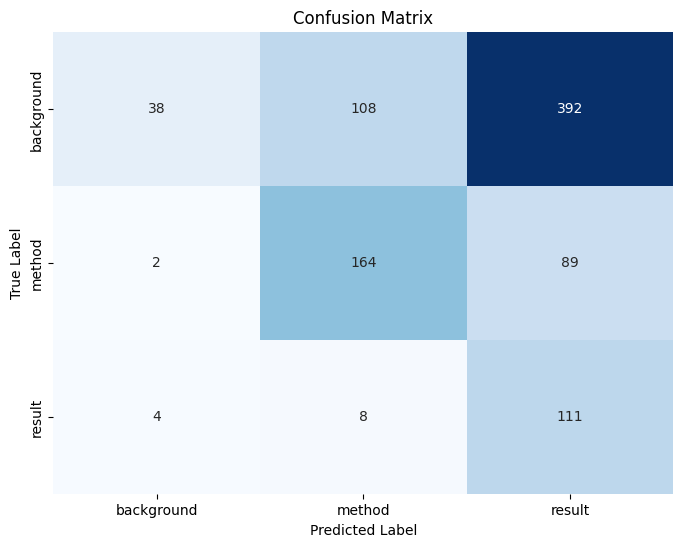

In [ ]:
import pandas as pd

# Specify the path to the CSV file
csv_file_path = 'inferred_classes_val.csv'

# Load the CSV file into a DataFrame
df_val = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df_val)


evaluate_multiclass_classification(df_val["true_class"], df_val["inferred_class"], ['background','method','result'])

In [ ]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df_val['check'] = df_val["true_class"] + df_val["inferred_class"]
# Count occurrences of each unique string in the 'check' column
check_counts2 = df_val['check'].value_counts()

# Display the result
print(check_counts2)

backgroundresult        392
methodmethod            164
resultresult            111
backgroundmethod        108
methodresult             89
backgroundbackground     38
resultmethod              8
resultbackground          4
methodbackground          2
Name: check, dtype: int64


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate the evaluation metrics.
precision_per_class = precision_score(df_val["true_class"], df_val["inferred_class"], average=None)
recall_per_class = recall_score(df_val["true_class"], df_val["inferred_class"], average=None)
f1_per_class = f1_score(df_val["true_class"], df_val["inferred_class"], average=None)

class_labels = ["background", "method", "result"]

# Print the evaluation metrics.
for i, (precision, recall, f1) in enumerate(zip(precision_per_class, recall_per_class, f1_per_class)):
    print(f'Class {i} ({class_labels[i]}): Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}')

Class 0 (background): Precision=0.8636, Recall=0.0706, F1-Score=0.1306
Class 1 (method): Precision=0.5857, Recall=0.6431, F1-Score=0.6131
Class 2 (result): Precision=0.1875, Recall=0.9024, F1-Score=0.3105
